In [108]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib 
import math
from matplotlib.ticker import FuncFormatter
from scipy import stats
'''
192.168.0.24: intensity context (old task), duration context (new task)
192.168.0.29: click rate task (old task), sweep direction (new task)
'''

'\n192.168.0.24: intensity context (old task), duration context (new task)\n192.168.0.29: click rate task (old task), sweep direction (new task)\n'

In [109]:
ALL = pd.read_csv("../Mante/ALL_6.20.25.csv").iloc[:,1:]
ALL = ALL.dropna()
subject_IDs = np.sort(ALL.subjects.unique())
# find the two tasks
INTENSITY = ALL[ALL.task == 24].reset_index(drop=True)
CLICKS = ALL[ALL.task == 29].reset_index(drop=True)

# Filter out the contaminated trials (approx. 500 trials)
# INTENSITY = INTENSITY[500:]
CLICKS = CLICKS[500:]
ALL = pd.concat([INTENSITY, CLICKS]).reset_index(drop=True)

In [110]:
# sanity check if the two rules are correct in the filtered data
# should have only two unique stimuli for each actioni in each rule
I_right = INTENSITY.loc[
    INTENSITY['trial_types'] == 1, 
    'specific_stims'
].unique()
I_left = INTENSITY.loc[
    INTENSITY['trial_types'] == 0, 
    'specific_stims'
].unique()
print(I_right)
print(I_left)

CR_right = CLICKS.loc[
    CLICKS['trial_types'] == 1, 
    'specific_stims'
].unique()
CR_left = CLICKS.loc[
    CLICKS['trial_types'] == 0, 
    'specific_stims'
].unique()
print(CR_right)
print(CR_left)

['clicks_12hz_1s_60db.wav' 'clicks_32hz_1s_60db.wav']
['clicks_12hz_1s_70db.wav' 'clicks_32hz_1s_70db.wav']
['clicks_12hz_1s_60db.wav' 'clicks_12hz_1s_70db.wav']
['clicks_32hz_1s_70db.wav' 'clicks_32hz_1s_60db.wav']


In [111]:
#                      I LOW 60 (RIGHT)           I HIGHT 70 (LEFT)        
# CR LOW 12 (RIGHT)     (context-invariant)       (context-dependent)
# CR HIGH 32 (LEFT)     (context-dependent)       (context-invariant)  

# the invariant stimuli are: 'clicks_12hz_1s_60db.wav', 'clicks_32hz_1s_70db.wav'
# the context-dependent stimuli are: 'clicks_12hz_1s_70db.wav', 'clicks_32hz_1s_60db.wav' 

In [112]:
# load context-dependent and invariant trials for each task
INVARIANT_INTENSITY = INTENSITY[
    (INTENSITY['specific_stims'] == 'clicks_12hz_1s_60db.wav')
    | 
    (INTENSITY['specific_stims'] == 'clicks_32hz_1s_70db.wav')
]
DEPENDENT_INTENSITY = INTENSITY[
    (INTENSITY['specific_stims'] == 'clicks_12hz_1s_70db.wav')
    | 
    (INTENSITY['specific_stims'] == 'clicks_32hz_1s_60db.wav')
]

INVARIANT_CLICKS = CLICKS[
    (CLICKS['specific_stims'] == 'clicks_12hz_1s_60db.wav')
    | 
    (CLICKS['specific_stims'] == 'clicks_32hz_1s_70db.wav')
]
DEPENDENT_CLICKS = CLICKS[
    (CLICKS['specific_stims'] == 'clicks_12hz_1s_70db.wav')
    | 
    (CLICKS['specific_stims'] == 'clicks_32hz_1s_60db.wav')
]

In [113]:
colors = ['#FFC07F', # Arena A -> intensity 
          '#94c47d', #  Arena B
          '#4AA9FC', # context-dep
          "#A1A7B0"] # context-inv

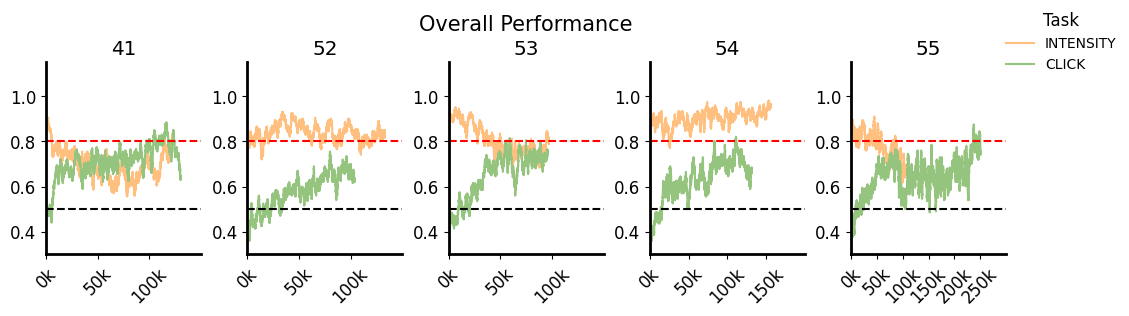

In [114]:
# plot the overall performance in both tasks
fig = plt.figure(figsize=(12, 6))
roll_size = 200
import matplotlib 
import math
matplotlib.rcParams['font.size'] = 12
idx = 1
for subject in subject_IDs:
    ax = plt.subplot(2, 5, idx)
    sub_intensity = INTENSITY.loc[INTENSITY.subjects == subject].reset_index(drop=True)
    sub_intensity.outcomes.rolling(roll_size).mean().plot(ax=ax,label="INTENSITY", color=colors[0])
    sub_clicks = CLICKS.loc[CLICKS.subjects == subject].reset_index(drop=True)
    sub_clicks.outcomes.rolling(roll_size).mean().plot(ax=ax,label="CLICK", color=colors[1])
    plt.title(f'{str(subject)[-2:]}')
    idx += 1
    ax.axhline(0.8, color='red', ls='--')
    ax.axhline(0.5, color='black', ls='--')
    x_max = max(len(sub_intensity), len(sub_clicks))
    if x_max < 15000:
        lim_x = 15000
    else:
        lim_x = math.ceil(x_max / 5000) * 5000
    ax.set_xlim(0, lim_x) 
    ax.set_xticks(np.arange(0, lim_x+1, 5000))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: f'{x/100:.0f}k'))
    last_tick  = ax.xaxis.get_major_ticks()[-1]   # grab final Tick object
    last_tick.set_visible(False)
    ax.set_ylim(0.3, 1.15)  
    ax.set_yticks(np.arange(0.4, 1.1, 0.2))

    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.subplots_adjust(
    hspace=0.5,    # increase vertical padding between rows
    wspace=0.3,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)
plt.suptitle('Overall Performance', fontsize=15)
handles, labels = ax.get_legend_handles_labels()

# add a single legend for the whole figure
fig.legend(
    handles,
    labels,
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    title='Task',
    fontsize = 10,
    frameon = False
)
plt.show()

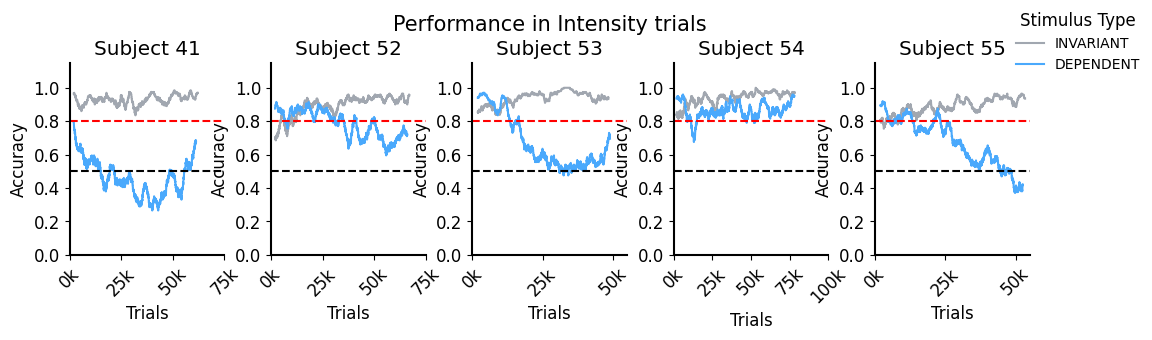

In [115]:
# plot separately for context-dependent and -invariant stimuli in INTENSITY trials
fig = plt.figure(figsize=(12, 6))
matplotlib.rcParams['font.size'] = 12
idx = 1
for subject in subject_IDs:
    ax = plt.subplot(2, 5, idx)
    sub_inv_intensity = INVARIANT_INTENSITY.loc[INVARIANT_INTENSITY.subjects == subject].reset_index(drop=True)
    sub_inv_intensity.outcomes.rolling(roll_size).mean().plot(ax=ax,label="INVARIANT", color=colors[3])
    sub_dep_intensity = DEPENDENT_INTENSITY.loc[DEPENDENT_INTENSITY.subjects == subject].reset_index(drop=True)
    sub_dep_intensity.outcomes.rolling(roll_size).mean().plot(ax=ax,label="DEPENDENT", color=colors[2])
    plt.title(f'Subject {str(subject)[-2:]}')
    idx += 1
    ax.axhline(0.8, color='red', ls='--')
    ax.axhline(0.5, color='black', ls='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    x_max = max(len(sub_inv_intensity), len(sub_dep_intensity))
    if x_max < 5500:
        lim_x = 5500
    else:
        lim_x = math.ceil(x_max / 2500) * 2500
    ax.set_xlim(0, lim_x) 
    ax.set_xticks(np.arange(0, lim_x+1, 2500))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: f'{x/100:.0f}k'))
    # last_tick  = ax.xaxis.get_major_ticks()[-1]   # grab final Tick object
    # last_tick.set_visible(False)
    ax.set_ylim(0, 1.15)  
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Trials')
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


plt.subplots_adjust(
    hspace=0.5,    # increase vertical padding between rows
    wspace=0.3,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)
plt.suptitle('Performance in Intensity trials', fontsize=15)
# collect handles + labels from the last axes (or any one axes—it’s the same labels)
handles, labels = ax.get_legend_handles_labels()

# add a single legend for the whole figure
fig.legend(
    handles,
    labels,
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    title='Stimulus Type',
    fontsize = 10,
    frameon = False
)
plt.show()

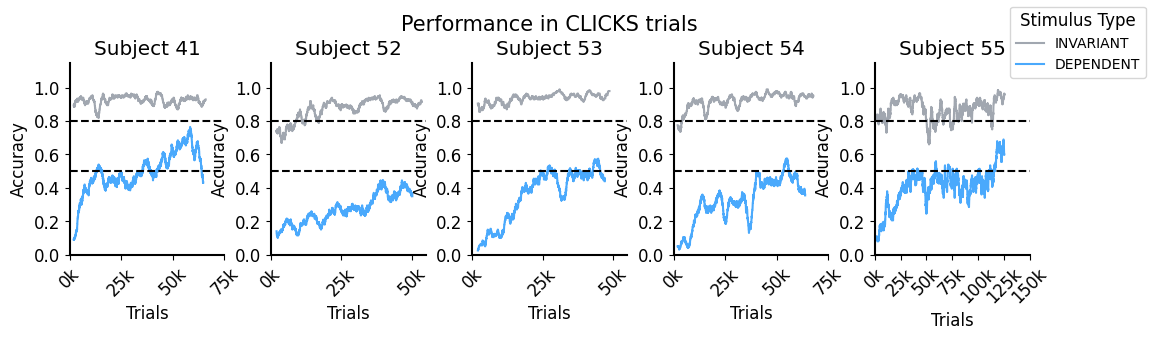

In [ ]:
# # plot separately for context-dependent and -invariant stimuli in CLICKS trials
fig = plt.figure(figsize=(12, 6))
matplotlib.rcParams['font.size'] = 12
idx = 1
for subject in subject_IDs:
    ax = plt.subplot(2, 5, idx)
    sub_inv_clicks = INVARIANT_CLICKS.loc[INVARIANT_CLICKS.subjects == subject].reset_index(drop=True)
    sub_inv_clicks.outcomes.rolling(roll_size).mean().plot(ax=ax,label="INVARIANT", color=colors[3])
    sub_dep_clicks = DEPENDENT_CLICKS.loc[DEPENDENT_CLICKS.subjects == subject].reset_index(drop=True)
    sub_dep_clicks.outcomes.rolling(roll_size).mean().plot(ax=ax,label="DEPENDENT", color=colors[2])
    plt.title(f'Subject {str(subject)[-2:]}')
    idx += 1
    ax.axhline(0.8, color='black', ls='--')
    ax.axhline(0.5, color='black', ls='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    x_max = max(len(sub_inv_clicks), len(sub_dep_clicks))
    if x_max < 5500:
        lim_x = 5500
    else:
        lim_x = math.ceil(x_max / 2500) * 2500
    ax.set_xlim(0, lim_x) 
    ax.set_xticks(np.arange(0, lim_x+1, 2500))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: f'{x/100:.0f}k'))
    ax.set_ylim(0, 1.15)  
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Trials')
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


plt.subplots_adjust(
    hspace=0.5,    # increase vertical padding between rows
    wspace=0.3,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)
plt.suptitle('Performance in CLICKS trials', fontsize=15)
# collect handles + labels from the last axes (or any one axes—it’s the same labels)
handles, labels = ax.get_legend_handles_labels()

# add a single legend for the whole figure
fig.legend(
    handles,
    labels,
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    title='Stimulus Type',
    fontsize=10
)
plt.show()

# Plot the swith frequency and initial performance

In [124]:
'''Helper functions'''
def process_block_data(subject_data):
    subject_data = subject_data.sort_values("times").reset_index(drop=True)
    subject_data["trial_idx"] = subject_data.index

    # (a) contiguous-block labels
    subject_data['block_id'] = subject_data['task'].ne(
        subject_data['task'].shift()
    ).cumsum()

    # (b) trial index *within* each block
    subject_data['within_block_idx'] = (
        subject_data
        .groupby('block_id')
        .cumcount()
    )

    # (c) block length for every trial 
    block_len = (
        subject_data.groupby('block_id')
        .size()
        .rename('block_len')
    )
    subject_data_processed = subject_data.join(block_len, on='block_id')
    return subject_data_processed

def boxplot_trialnum(subject_data_processed, subject, ax):
    block_len_df = (
        subject_data_processed[['task', 'block_id', 'block_len']]
        .drop_duplicates()
        .reset_index(drop=True)
    )

    Intensity_len = block_len_df.loc[block_len_df['task'] == 24, 'block_len']
    Cr_len = block_len_df.loc[block_len_df['task'] == 29, 'block_len']
    data = [Intensity_len, Cr_len]

    palette = {24: colors[0], 29: colors[1]} 

    bp = ax.boxplot(
        data,
        patch_artist=True,
        widths=0.6,
        positions=[1.0, 1.75],
        boxprops    = dict(edgecolor='black',linewidth = 1.5),
        medianprops = dict(color='black', linewidth=1.5),
        whiskerprops= dict(color='black'),
        capprops    = dict(color='black')
    )

    box_colors = [palette[24], palette[29]]
    for box, col in zip(bp['boxes'], box_colors):
        box.set_facecolor(col)
        box.set_alpha(0.8) 

    rng      = np.random.default_rng(1)
    jitter   = 0
    dot_area = 55

    # Intensity dots (blue)
    x24 = 1 + rng.uniform(-jitter, jitter, len(Intensity_len))
    ax.scatter(
        x24, Intensity_len,
        marker='o',
        s=dot_area,
        facecolors=palette[24],   # your blue
        edgecolors='black',
        linewidths=0.8,
        zorder=2
    )
    ax.set_title(f'Subject {str(subject)[-2:]}')
    # CR dots (orange)
    x29 = 1.75 + rng.uniform(-jitter, jitter, len(Cr_len))
    ax.scatter(
        x29, Cr_len,
        marker='o',
        s=dot_area,
        facecolors=palette[29],   # your orange
        edgecolors='black',
        linewidths=0.8,
        zorder=2
    )

    # ax.set_ylim([-100,750])
    ax.set_xlim([0.5, 2.1])
    ax.set_xticklabels(['Arena A', 'Arena B'], fontsize = 8)
    ax.set_ylabel('# trials before switch')
    ax.grid(axis='y', linestyle='--', alpha=0.35)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.tight_layout()
    # plt.savefig('switch_frequency.pdf',bbox_inches='tight')
    # plt.show()
    return Intensity_len, Cr_len
    
def trial_length_average_and_ttest(Intensity_len, Cr_len):
    t_stat, p_val = stats.ttest_ind(Intensity_len, Cr_len, equal_var=False)  # Welch’s t-test
    if p_val > 0.05:
        print(f'Subject stays in either arena does NOT significantly differ: t = {t_stat:.3f},  p = {p_val:.4f}')
    else:
        print(f'Subject stays in either arena DOES significantly differ: t = {t_stat:.3f},  p = {p_val:.4f}')
    Intensity_len_mean = np.mean(Intensity_len)
    Intensity_len_se = Intensity_len.std(ddof=1) / np.sqrt(len(Intensity_len))
    Cr_len_mean = np.mean(Cr_len)
    Cr_len_se = Cr_len.std(ddof=1) / np.sqrt(len(Cr_len))
    print(f'Intensity task on average runs for {Intensity_len_mean} trials +- {Intensity_len_se:.2f}')
    print(f'Click Rate task on average runs for {Cr_len_mean} trials +- {Cr_len_se:.2f}')

def plot_afterswitch_performance(subject_data, subject, ax, max_k = 20):
    palette = {24: colors[0], 29: colors[1]} 
    trimmed = subject_data[subject_data['within_block_idx'] < max_k].copy()

    summ = (
        trimmed
        .groupby(['task', 'within_block_idx'])['outcomes']
        .agg(mean='mean', count='count', std='std')
        .reset_index()
    )
    summ['sem'] = summ['std'] / np.sqrt(summ['count'])

    #smoothing
    for col in ['mean', 'sem']:
        summ[f'smooth_{col}'] = (
            summ
            .groupby('task')[col]
            .transform(lambda s: s.rolling(3,
                                            center=True,
                                            min_periods=1).mean())
        )

    for task_val in (24, 29):
        g  = summ[summ['task'] == task_val]
        x  = g['within_block_idx']
        m  = g['smooth_mean']
        se = g['smooth_sem']
        cur_label = 'Arena A' if task_val == 24 else 'Arena B'
        ax.plot(x, m, color=palette[task_val], label=cur_label)
        ax.fill_between(x, m - se, m + se,
                        color=palette[task_val], alpha=0.25)
    ax.set_title(f'Subject {str(subject)[-2:]}')
    ax.axhline(0.8, color='red', ls='--')
    ax.axhline(0.5, color='black', ls='--')
    ax.set_xlim(-0.5, max_k - 0.5)
    ax.set_xlabel('Trials', fontsize = 9)
    ax.set_ylabel('Accuracy',fontsize = 9)
    ax.set_ylim(0.3, 1.15)  
    ax.set_yticks(np.arange(0.4, 1.1, 0.2))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.tight_layout()
    # plt.savefig('after_switch_accuray.pdf',bbox_inches='tight')
    # plt.show()


Subject stays in either arena does NOT significantly differ: t = -0.352,  p = 0.7255
Intensity task on average runs for 87.39716312056737 trials +- 12.81
Click Rate task on average runs for 92.56737588652483 trials +- 7.23
Subject stays in either arena does NOT significantly differ: t = 1.646,  p = 0.1010
Intensity task on average runs for 87.5657894736842 trials +- 9.46
Click Rate task on average runs for 68.32236842105263 trials +- 6.87
Subject stays in either arena does NOT significantly differ: t = 0.092,  p = 0.9265
Intensity task on average runs for 83.1880341880342 trials +- 11.11
Click Rate task on average runs for 81.92307692307692 trials +- 8.01
Subject stays in either arena does NOT significantly differ: t = 1.108,  p = 0.2690
Intensity task on average runs for 106.38775510204081 trials +- 12.45
Click Rate task on average runs for 90.04794520547945 trials +- 7.90
Subject stays in either arena DOES significantly differ: t = -2.417,  p = 0.0162
Intensity task on average runs f

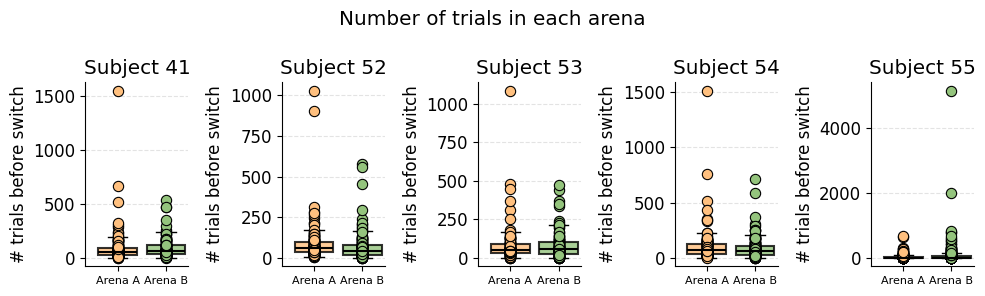

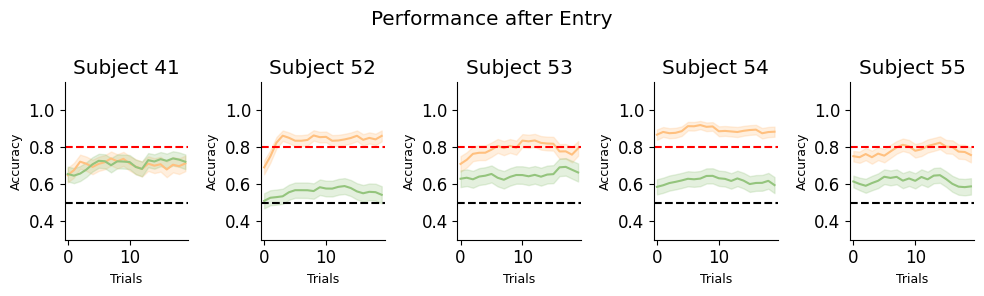

In [125]:
fig1, axgrid1 = plt.subplots(1, 5, figsize=(10, 3))   # box-plots
fig2, axgrid2 = plt.subplots(1, 5, figsize=(10, 3))   # after-switch curves

matplotlib.rcParams['font.size'] = 12
for idx, subject in enumerate(subject_IDs):
    # row, col = divmod(idx, 5)
    
    ax1   = axgrid1[idx]      
    ax2 = axgrid2[idx] 

    subject_data = ALL.loc[ALL.subjects == subject].reset_index(drop=True)
    subject_data_processed = process_block_data(subject_data)
    Intensity_len, Cr_len = boxplot_trialnum(subject_data_processed, subject, ax1)
    trial_length_average_and_ttest(Intensity_len, Cr_len)
    plot_afterswitch_performance(subject_data_processed, subject, ax2)

fig1.suptitle('Number of trials in each arena')
fig1.tight_layout()
fig2.suptitle('Performance after Entry')
fig2.tight_layout()

plt.show()